In [187]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import TomekLinks
from imblearn.pipeline import Pipeline
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_classification
from imblearn.combine import SMOTETomek
from sklearn.preprocessing import normalize
import re
import seaborn as sns
from scipy import stats
import xgboost as xgb

/opt/homebrew/Caskroom/miniforge/base/envs/pytorch_env/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [137]:
orig_data = pd.read_excel("OppScrData.xlsx")
#print(orig_data)
for col in orig_data.columns:
    if 'Unnamed' in col:
        orig_data.drop(columns=col, inplace=True)
    else:
        new_col = '_'.join(col.split())
        orig_data.rename(columns={col:new_col}, inplace=True)
#for col in orig_data.columns:
#    print(col)
#print(orig_data.columns)
#print(orig_data)

In [138]:
data = orig_data.copy()

##Can use clinal_fu_Interval to get weights of clinical features

ct_feats = ['L1_HU_BMD',
       'TAT_Area_(cm2)', 'Total_Body_Area_EA_(cm2)', 'VAT_Area_(cm2)',
       'SAT_Area_(cm2)', 'VAT/SAT_Ratio', 'Muscle_HU', 'Muscle_Area_(cm2)', 
       'L3_SMI_(cm2/m2)', 'AoCa_Agatston', 'Liver_HU_(Median)']
clinal_feats = ['BMI_>30', 'Sex', 'Age_at_CT', 'Tobacco', 'Alcohol_abuse', 'FRS_10-year_risk_(%)', 'FRAX_10y_Fx_Prob_(Orange-w/_DXA)', 'FRAX_10y_Hip_Fx_Prob_(Orange-w/_DXA)', 'Met_Sx']
other_feats = ['Record_ID', 'Visit_ID', 'PT_ID']
outcome = ['DEATH_[d_from_CT]']

myfilter = []
myfilter.extend(ct_feats)
myfilter.extend(outcome)

data_ct = data.loc[:, myfilter]
data = data_ct
#print(data.shape)

col = 'Liver_HU_(Median)'
data.loc[:, col] = pd.to_numeric(data[col], errors='coerce')
data.loc[:, col] = data[col].astype(float)
#print(data)

col = 'DEATH_[d_from_CT]'
#print(data.head(10))
#print(orig_data)
#data.loc[~data[col].isna(), col] = 1
#data.loc[data[col].isna(), col] = 0
#print(data.shape)
#print(data[col])
#print(data.head(10))
#print(data.loc[data[col] == 0, :].shape)
data.rename(columns={col:'death'}, inplace=True)
col = 'death'
#print(data.head(10))
#print(data.loc[data[col] == 0, :].shape)
#print(train.shape)
#print(test)
label = col

#print(data.loc[18, label])

5070.0


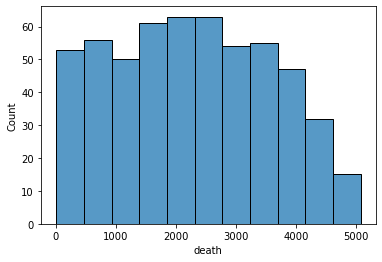

0.0
0.1111111111111111
0.0
563.3333333333333
11.275661349376177
0.26743979351863867


<AxesSubplot:xlabel='death_recency', ylabel='Count'>

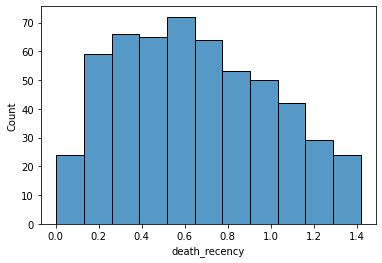

In [139]:
data[label] = data[label].fillna(0)
#print(data[label])
sns.histplot(data.loc[data[label] > 0, label])
val_range = max(data[label]) - min(data[label])
print(val_range)
plt.show()
#for i in range(len(data[label])):
#    if data[i, label] > 0:
#        data[i]['death_recency'] = val_range/data[i][label]
data.loc[data[label] == 0 ,'death_recency'] = 0
data.loc[data[label] > 0 ,'death_recency'] = 1/data[label]

print(min(data['death_recency']))
print(max(data['death_recency']))
data['death_recency'] = data['death_recency'] * val_range
#data['death_recency'] = data['death_recency'].fillinf(0)
print(min(data['death_recency']))
print(max(data['death_recency']))

data_nz = data.loc[data['death_recency'] > 0, :].copy()
#X = data_nz['death_recency'].copy()
print(pd.Series(data_nz['death_recency']).skew())
data_nz['death_recency'] = stats.boxcox(data_nz['death_recency'])[0]
print(pd.Series(data_nz['death_recency']).skew())

data.loc[data['death_recency'] > 0, 'death_recency'] = data_nz['death_recency']

sns.histplot(data.loc[data['death_recency'] > 0, 'death_recency'])

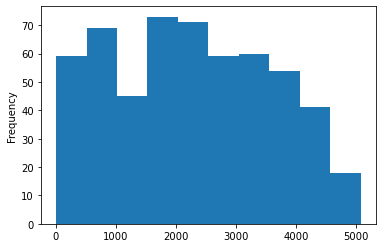

<AxesSubplot:xlabel='death', ylabel='Count'>

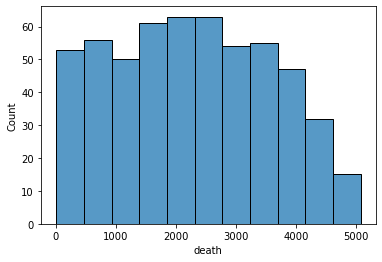

In [134]:
data[label].plot.hist()
plt.show()
sns.histplot(data.loc[data[label] > 0, label])

## EDA

In [61]:
orig_data[~orig_data['DEATH_[d_from_CT]'].isna()].shape

(549, 116)

<AxesSubplot:ylabel='Frequency'>

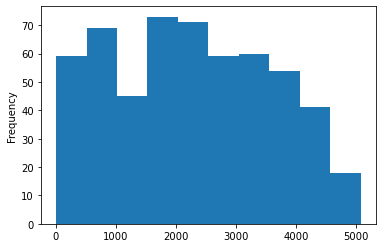

In [62]:
orig_data[orig_data['DEATH_[d_from_CT]']<5071]['DEATH_[d_from_CT]'].plot.hist()

In [63]:
"""
train.groupby('DEATH_[d_from_CT]')['L1_HU_BMD',
       'TAT_Area_(cm2)', 'Total_Body_Area_EA_(cm2)', 'VAT_Area_(cm2)',
       'SAT_Area_(cm2)', 'VAT/SAT_Ratio', 'Muscle_HU', 'Muscle_Area_(cm2)',
       'L3_SMI_(cm2/m2)', 'AoCa_Agatston', 'Liver_HU_(Median)'].describe().T[48:]
"""

"\ntrain.groupby('DEATH_[d_from_CT]')['L1_HU_BMD',\n       'TAT_Area_(cm2)', 'Total_Body_Area_EA_(cm2)', 'VAT_Area_(cm2)',\n       'SAT_Area_(cm2)', 'VAT/SAT_Ratio', 'Muscle_HU', 'Muscle_Area_(cm2)',\n       'L3_SMI_(cm2/m2)', 'AoCa_Agatston', 'Liver_HU_(Median)'].describe().T[48:]\n"

In [104]:

for col in train.columns:
    print(col)
    sns.boxplot(x=label, y=col, data=train)
    plt.show()

L1_HU_BMD


ValueError: Could not interpret input 'death_recency'

In [65]:
def plot_2d_space(X, y, label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()

## SMOTE (Classification)

In [158]:
data_2 = data.copy()

#data_2 = data_2.drop(columns='death')
#label = 'death_recency'

data_2 = data_2.drop(columns='death_recency')
label = 'death'


#data_2 = data_2.loc[data_2[label] > 0]

msk = np.random.rand(data_2.shape[0]) < 0.8
#print(msk)
train = data_2[msk]
test = data_2[~msk]

X_train = train[ct_feats]
y_train = train[label]
X_train = X_train.fillna(0)
y_train = y_train.fillna(0)

X_test = test[ct_feats]
Y_test = test[label]
X_test = X_test.fillna(0)
Y_test = Y_test.fillna(0)

print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(Y_test.shape)

(455, 11)
(455,)
(94, 11)
(94,)


In [153]:
print(Counter(y_train))

"""
#smt = SMOTETomek()
smt = SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))
X_train, y_train = smt.fit_resample(X_train, y_train)
"""

#"""
over = SMOTE(sampling_strategy=0.1)
#over = SMOTE()
under = RandomUnderSampler(sampling_strategy=0.5)
#under = TomekLinks()
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
# transform the dataset
X_train, y_train = pipeline.fit_resample(X_train, y_train)
#"""


# summarize the new class distribution#
print(Counter(y_train))
#print(X_train.head(10))
#print(y_train.head(10))


Counter({0.7038849442152807: 2, 0.5929564454826937: 2, 0.4286113242758025: 2, 0.6318933286736683: 2, 0.23485951293203597: 2, 1.4169629165851008: 2, 0.6425851574213822: 2, 0.5635872278392423: 2, 0.2483219137507131: 2, 0.8118964470174688: 2, 0.8255668096737596: 2, 0.4013865414190723: 2, 1.3344091489255843: 2, 1.2065578881097079: 2, 0.08108514737537452: 2, 0.6628681921035418: 2, 0.14237937906643697: 2, 0.6682988298464172: 1, 0.7829916039444261: 1, 1.1825352514609284: 1, 0.7760600386823532: 1, 0.2958661630918987: 1, 0.28368334329554673: 1, 0.51804313479439: 1, 0.4201125386953553: 1, 0.6127015618587097: 1, 0.5120612054434481: 1, 0.8562410221364191: 1, 0.5996819241690166: 1, 0.6662280497808841: 1, 0.34340045063866126: 1, 0.2854203061552774: 1, 0.7521803099738507: 1, 0.1910786054044178: 1, 0.6288498865242124: 1, 1.0349957533892296: 1, 0.1019910523490772: 1, 1.141138308423602: 1, 1.1427123707190923: 1, 0.23677868279253667: 1, 0.9060670736635008: 1, 0.5560071282400754: 1, 0.8020102122368216: 1,

ValueError: Unknown label type: 'continuous'

In [ ]:
ax= plt.subplot()
cm = confusion_matrix(Y_test, preds)
labels = [0,1]
sns.heatmap(cm, annot=True, fmt='g', ax=ax);
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels);
ax.yaxis.set_ticklabels(labels);

## Regression

In [211]:
data_2 = data.copy()

#data_2 = data_2.drop(columns='death')
#label = 'death_recency'

data_2 = data_2.drop(columns='death_recency')
label = 'death'


data_2 = data_2.loc[data_2[label] > 0]

msk = np.random.rand(data_2.shape[0]) < 0.8
#print(msk)
train = data_2[msk]
test = data_2[~msk]

X_train = train[ct_feats]
y_train = train[label]
X_train = X_train.fillna(0)
y_train = y_train.fillna(0)

X_test = test[ct_feats]
Y_test = test[label]
X_test = X_test.fillna(0)
Y_test = Y_test.fillna(0)

print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(Y_test.shape)

(443, 11)
(443,)
(106, 11)
(106,)


In [212]:

#print(X_train)
#print(y_train)
model = xgb.XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=1, colsample_bytree=1)
model.fit(X_train, y_train)
#model = LinearRegression().fit(X_train, y_train)
#model = DecisionTreeClassifier(random_state=0).fit(X_train, y_train)
# evaluate pipeline
#cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
#scores = cross_val_score(model, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
#print('Mean ROC AUC: %.3f' % np.mean(scores))

/opt/homebrew/Caskroom/miniforge/base/envs/pytorch_env/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             eta=0.1, gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.100000001,
             max_delta_step=0, max_depth=7, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [213]:
#print(Counter(Y_test))
preds = model.predict(X_test)
math.sqrt(mean_squared_error(Y_test, preds))

1485.1449980657956

In [214]:
Y_test.mean()

2062.509433962264

<AxesSubplot:xlabel='Y_test', ylabel='preds'>

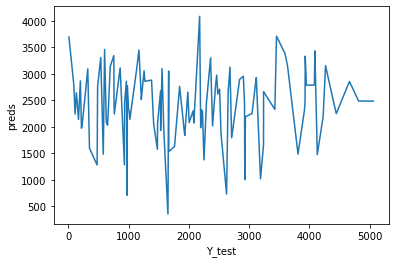

In [215]:
tmp = {'Y_test':Y_test,'preds':preds} 
# tmp_df = pd.DataFrame([Y_test, preds], columns=['Y_test','preds'])
tmp_df = pd.DataFrame(tmp)
tmp_df.sort_values(by='Y_test', inplace=True)
sns.lineplot(data=tmp_df, x='Y_test', y='preds')

In [216]:
##use this model to predict on rows of data that are zeros. expect average prediction to be higher.
data_2 = data.copy()

#data_2 = data_2.drop(columns='death')
#label = 'death_recency'

data_2 = data_2.drop(columns='death_recency')
label = 'death'


#data_2 = data_2.loc[data_2[label] > 0]

msk = np.random.rand(data_2.shape[0]) < 0.8
#print(msk)
train = data_2[msk]
test = data_2[~msk]

X_train = train[ct_feats]
y_train = train[label]
X_train = X_train.fillna(0)
y_train = y_train.fillna(0)

X_test = test[ct_feats]
Y_test = test[label]
X_test = X_test.fillna(0)
Y_test = Y_test.fillna(0)

print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(Y_test.shape)

(7356, 11)
(7356,)
(1867, 11)
(1867,)


In [217]:
preds = model.predict(X_test)
print(Y_test.mean())
math.sqrt(mean_squared_error(Y_test, preds))

126.8709159078736


/opt/homebrew/Caskroom/miniforge/base/envs/pytorch_env/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


2454.1892785271357

<AxesSubplot:xlabel='Y_test', ylabel='preds'>

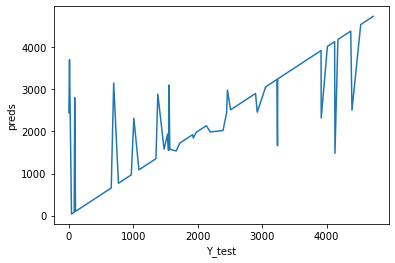

In [218]:
tmp = {'Y_test':Y_test,'preds':preds} 
# tmp_df = pd.DataFrame([Y_test, preds], columns=['Y_test','preds'])
tmp_df = pd.DataFrame(tmp)
tmp_df.sort_values(by='Y_test', inplace=True)
sns.lineplot(data=tmp_df, x='Y_test', y='preds')

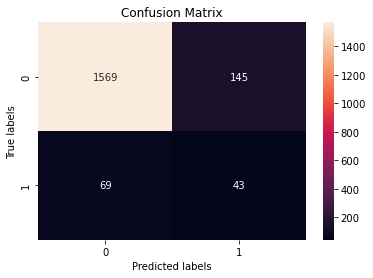

In [30]:
ax= plt.subplot()
cm = confusion_matrix(Y_test, preds)
labels = [0,1]
sns.heatmap(cm, annot=True, fmt='g', ax=ax);
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels);
ax.yaxis.set_ticklabels(labels);

## Predict Diabetes

In [153]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import TomekLinks
from imblearn.pipeline import Pipeline
from collections import Counter
#from c.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.datasets import make_classification
from imblearn.combine import SMOTETomek

In [154]:
orig_data = pd.read_excel("OppScrData.xlsx")
#print(orig_data)
for col in orig_data.columns:
    new_col = '_'.join(col.split())
    orig_data.rename(columns={col:new_col}, inplace=True)
    print(new_col)
#print(orig_data.columns)
#print(orig_data)

Record_ID
Visit_ID
PT_ID
Clinical_F/U_interval_[d_from_CT]
BMI
BMI_>30
Sex
Age_at_CT
Tobacco
Alcohol_abuse
FRS_10-year_risk_(%)
FRAX_10y_Fx_Prob_(Orange-w/_DXA)
FRAX_10y_Hip_Fx_Prob_(Orange-w/_DXA)
Met_Sx
CLINICAL_OUTCOMES
DEATH_[d_from_CT]
CVD_DX
CVD_DX_Date_[d_from_CT]
Heart_failure_DX
Heart_failure_DX_Date_[d_from_CT]
MI_DX
MI_DX_Date_[d_from_CT]
Type_2_Diabetes_DX
Type_2_Diabetes_DX_Date_[d_from_CT]
Femoral_neck_fracture_DX
Femoral_neck_fracture_DX_Date_[d_from_CT]
Unspec_femoral_fracture_DX
Unspec_femoral_fracture_DX_Date_[d_from_CT]
Forearm_fracture_DX
Forearm_fracture_DX_Date_[d_from_CT]
Humerus_fracture_DX
Humerus_fracture_DX_Date_[d_from_CT]
Pathologic_fracture_DX
Pathologic_fracture_DX_Date_[d_from_CT]
Alzheimers_DX
Alzheimers_DX_Date_[d_from_CT]
Primary_Cancer_Site
Primary_Cancer_Dx_[d_from_CT]
Primary_Cancer_Site_2
Primary_Cancer_Site_2_Dx_[d_from_CT]
AUTO-CT_VALUES
L1_HU_BMD
TAT_Area_(cm2)
Total_Body_Area_EA_(cm2)
TAT/Area
VAT_Area_(cm2)
SAT_Area_(cm2)
VAT/SAT_Ratio
Muscle

In [205]:
data = orig_data.copy()
data.fillna(0)
col = 'Primary_Cancer_Dx_[d_from_CT]'
data.loc[~data[col].isna(), col] = 1
data.loc[data[col].isna(), col] = 0

col = 'Primary_Cancer_Site_2_Dx_[d_from_CT]'
data.loc[~data[col].isna(), col] = 1
data.loc[data[col].isna(), col] = 0


Counter(data[col])
#data = data.loc[:, ['Record_ID', 'Visit_ID', 'PT_ID','DEATH_[d_from_CT]','L1_HU_BMD',
#       'TAT_Area_(cm2)', 'Total_Body_Area_EA_(cm2)', 'VAT_Area_(cm2)',
#       'SAT_Area_(cm2)', 'VAT/SAT_Ratio', 'Muscle_HU', 'Muscle_Area_(cm2)',
#      'L3_SMI_(cm2/m2)', 'AoCa_Agatston', 'Liver_HU_(Median)', 'Type_2_Diabetes_DX']]

#all_feats = ['BMI_>30', 'Sex', 'Age_at_CT', 'Tobacco', 'Alcohol_abuse', 
#                    'Met_Sx', 'L1_HU_BMD', 'TAT_Area_(cm2)', 'Total_Body_Area_EA_(cm2)', 
#                    'VAT_Area_(cm2)', 'SAT_Area_(cm2)', 'VAT/SAT_Ratio', 'Muscle_HU', 'Muscle_Area_(cm2)',
#                   'L3_SMI_(cm2/m2)', 'AoCa_Agatston', 'Liver_HU_(Median)']

ncol = 'double_cancer'
data[ncol] = (data['Primary_Cancer_Dx_[d_from_CT]'] != 0) & (data['Primary_Cancer_Site_2_Dx_[d_from_CT]'] != 0)
print(Counter(data[ncol]))
#data.loc[(data['Primary_Cancer_Dx_[d_from_CT]'] != 0) and (data['Primary_Cancer_Site_2_Dx_[d_from_CT]'] != 0), ncol] = 1


feats = ['BMI_>30', 'Sex', 'Age_at_CT', 'Tobacco', 'Alcohol_abuse', 
                    'Met_Sx', 'L1_HU_BMD', 'TAT_Area_(cm2)', 'Total_Body_Area_EA_(cm2)', 
                    'VAT_Area_(cm2)', 'SAT_Area_(cm2)', 'VAT/SAT_Ratio', 'Muscle_HU', 'Muscle_Area_(cm2)',
                   'L3_SMI_(cm2/m2)', 'AoCa_Agatston', 'Liver_HU_(Median)']

labels = ['CVD_DX', 'Heart_failure_DX', 'MI_DX', 'Type_2_Diabetes_DX', 'Alzheimers_DX', 'Primary_Cancer_Dx_[d_from_CT]', 'Primary_Cancer_Site_2_Dx_[d_from_CT]', 'double_cancer']
main_label = 'DEATH_[d_from_CT]'





feat_label = []
feat_label.extend(feats)
feat_label.extend(labels)
feat_label.append(main_label)
#feat_label.append('Type_2_Diabetes_DX_Date_[d_from_CT]')
data = data.loc[:, feat_label]

for col in labels:
    data.loc[~data[col].isna(), col] = 1
    data.loc[data[col].isna(), col] = 0

col = 'DEATH_[d_from_CT]'
data.loc[~data[col].isna(), col] = 1
data.loc[data[col].isna(), col] = 0


#print(data['Type_2_Diabetes_DX'])
col = 'Liver_HU_(Median)'
data.loc[:, col] = pd.to_numeric(data[col], errors='coerce')
data.loc[:, col] = data[col].astype(float)

#col = 'Type_2_Diabetes_DX_Date_[d_from_CT]'
#ncol = 'Pre_diabetic'
#data.loc[data[col] <= 0, ncol] = 1
#data.loc[data[col] > 0, ncol] = 0

data.loc[data['BMI_>30'] == 'Y', 'BMI_>30'] = 1
data.loc[data['BMI_>30'] == 'N', 'BMI_>30'] = 0

data.loc[data['Sex'] == 'Male', 'Sex'] = 1
data.loc[data['Sex'] == 'Female', 'Sex'] = 0

data.loc[data['Tobacco'] == 'Yes', 'Tobacco'] = 1
data.loc[data['Tobacco'] == 'No', 'Tobacco'] = 0

col = 'Alcohol_abuse'
data.loc[~data[col].isna(), col] = 1
data.loc[data[col].isna(), col] = 0

data.loc[data['Met_Sx'] == 'Y', 'Met_Sx'] = 1
data.loc[data['Met_Sx'] == 'N', 'Met_Sx'] = 0


#normalize(data[label])
#print(data[label])

data = data.fillna(0)

print(data.shape)
#"""
#print(Counter(data['BMI_>30'] == 0))
#print(Counter(data.loc[data[label==0], label]))

Counter({False: 9099, True: 124})
(9223, 26)


In [210]:
for col in labels:
    print(data.groupby([col,main_label])[main_label].count())

CVD_DX  DEATH_[d_from_CT]
0       0.0                  7941
        1.0                   381
1       0.0                   733
        1.0                   168
Name: DEATH_[d_from_CT], dtype: int64
Heart_failure_DX  DEATH_[d_from_CT]
0                 0.0                  8214
                  1.0                   366
1                 0.0                   460
                  1.0                   183
Name: DEATH_[d_from_CT], dtype: int64
MI_DX  DEATH_[d_from_CT]
0      0.0                  7999
       1.0                   383
1      0.0                   675
       1.0                   166
Name: DEATH_[d_from_CT], dtype: int64
Type_2_Diabetes_DX  DEATH_[d_from_CT]
0                   0.0                  6344
                    1.0                   343
1                   0.0                  2330
                    1.0                   206
Name: DEATH_[d_from_CT], dtype: int64
Alzheimers_DX  DEATH_[d_from_CT]
0              0.0                  8643
               1.0   

## DIABETES CLASSIFICATION

In [155]:
data = orig_data.copy()

#data = data.loc[:, ['Record_ID', 'Visit_ID', 'PT_ID','DEATH_[d_from_CT]','L1_HU_BMD',
#       'TAT_Area_(cm2)', 'Total_Body_Area_EA_(cm2)', 'VAT_Area_(cm2)',
#       'SAT_Area_(cm2)', 'VAT/SAT_Ratio', 'Muscle_HU', 'Muscle_Area_(cm2)',
#      'L3_SMI_(cm2/m2)', 'AoCa_Agatston', 'Liver_HU_(Median)', 'Type_2_Diabetes_DX']]

#all_feats = ['BMI_>30', 'Sex', 'Age_at_CT', 'Tobacco', 'Alcohol_abuse', 
#                    'Met_Sx', 'L1_HU_BMD', 'TAT_Area_(cm2)', 'Total_Body_Area_EA_(cm2)', 
#                    'VAT_Area_(cm2)', 'SAT_Area_(cm2)', 'VAT/SAT_Ratio', 'Muscle_HU', 'Muscle_Area_(cm2)',
#                   'L3_SMI_(cm2/m2)', 'AoCa_Agatston', 'Liver_HU_(Median)']

feats = ['BMI_>30', 'Sex', 'Age_at_CT', 'Tobacco', 'Alcohol_abuse', 
                    'Met_Sx', 'L1_HU_BMD', 'TAT_Area_(cm2)', 'Total_Body_Area_EA_(cm2)', 
                    'VAT_Area_(cm2)', 'SAT_Area_(cm2)', 'VAT/SAT_Ratio', 'Muscle_HU', 'Muscle_Area_(cm2)',
                   'L3_SMI_(cm2/m2)', 'AoCa_Agatston', 'Liver_HU_(Median)']

feat_label = []
feat_label.extend(feats)
feat_label.append('Type_2_Diabetes_DX')
#feat_label.append('Type_2_Diabetes_DX_Date_[d_from_CT]')
data = data.loc[:, feat_label]


#print(data['Type_2_Diabetes_DX'])
col = 'Liver_HU_(Median)'
data.loc[:, col] = pd.to_numeric(data[col], errors='coerce')
data.loc[:, col] = data[col].astype(float)

#col = 'Type_2_Diabetes_DX_Date_[d_from_CT]'
#ncol = 'Pre_diabetic'
#data.loc[data[col] <= 0, ncol] = 1
#data.loc[data[col] > 0, ncol] = 0

data.loc[data['BMI_>30'] == 'Y', 'BMI_>30'] = 1
data.loc[data['BMI_>30'] == 'N', 'BMI_>30'] = 0

data.loc[data['Sex'] == 'Male', 'Sex'] = 1
data.loc[data['Sex'] == 'Female', 'Sex'] = 0

data.loc[data['Tobacco'] == 'Yes', 'Tobacco'] = 1
data.loc[data['Tobacco'] == 'No', 'Tobacco'] = 0

col = 'Alcohol_abuse'
data.loc[~data[col].isna(), col] = 1
data.loc[data[col].isna(), col] = 0

data.loc[data['Met_Sx'] == 'Y', 'Met_Sx'] = 1
data.loc[data['Met_Sx'] == 'N', 'Met_Sx'] = 0


"""
col = 'Type_2_Diabetes_DX_Date_[d_from_CT]'
label = 'diabetes_days'
data.rename(columns={col:label}, inplace=True)
data = data.fillna(0)

min(data[label]) = 
normalize(data[:, label])
print(data[label])
"""


col = 'Type_2_Diabetes_DX'
label = 'diabetes'
data.rename(columns={col:label}, inplace=True)

data.loc[~data[label].isna(), label] = 1
data.loc[data[label].isna(), label] = 0

#normalize(data[label])
#print(data[label])

data = data.fillna(0)

print(data.shape)
#"""
#print(Counter(data['BMI_>30'] == 0))
#print(Counter(data.loc[data[label==0], label]))

(9223, 18)


BMI_>30


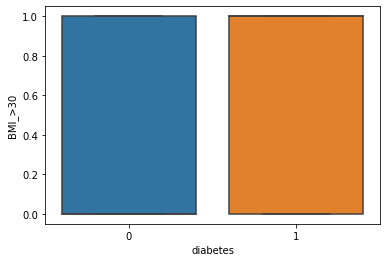

Sex


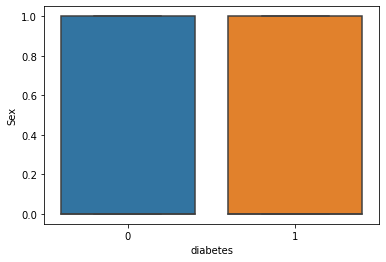

Age_at_CT


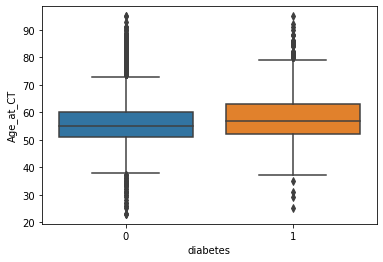

Tobacco


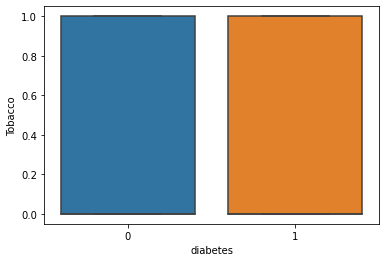

Alcohol_abuse


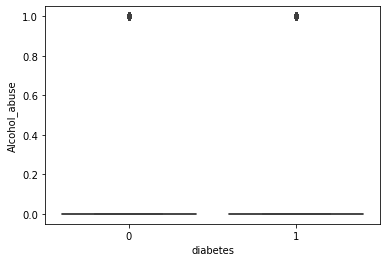

Met_Sx


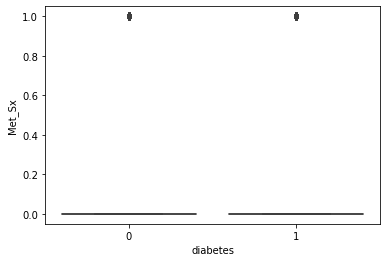

L1_HU_BMD


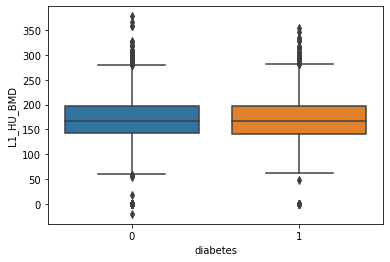

TAT_Area_(cm2)


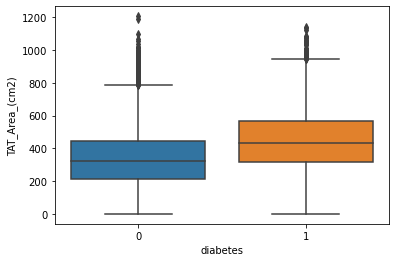

Total_Body_Area_EA_(cm2)


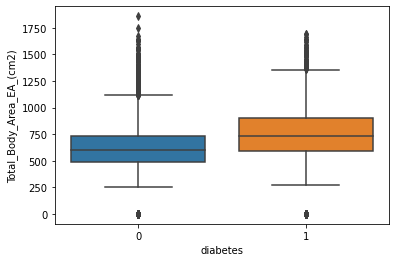

VAT_Area_(cm2)


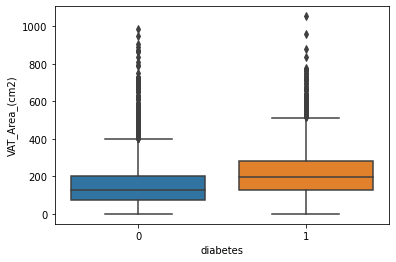

SAT_Area_(cm2)


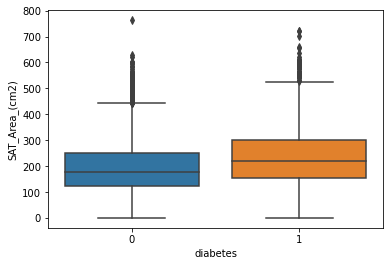

VAT/SAT_Ratio


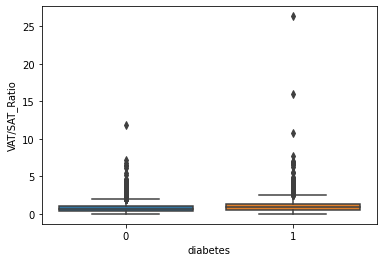

Muscle_HU


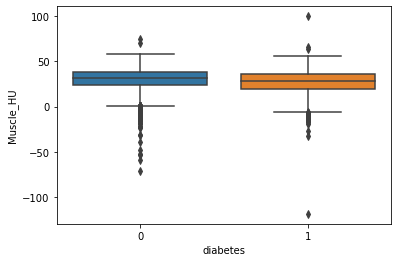

Muscle_Area_(cm2)


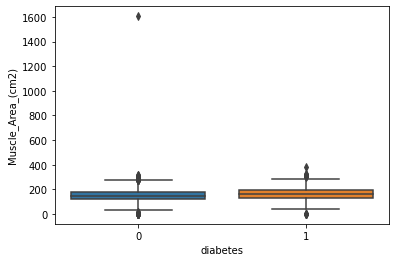

L3_SMI_(cm2/m2)


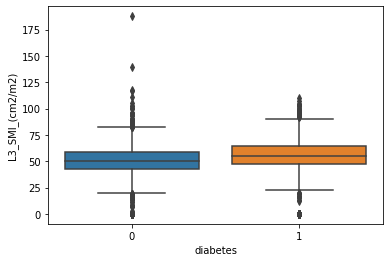

AoCa_Agatston


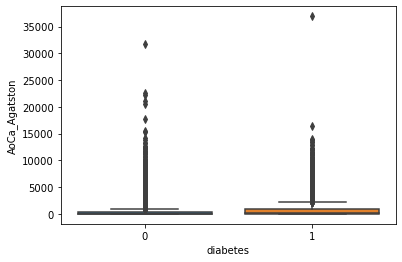

Liver_HU_(Median)


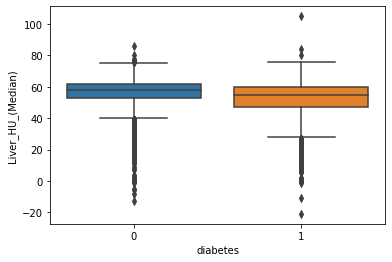

diabetes


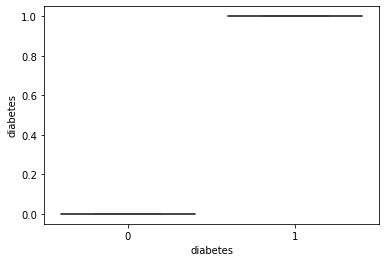

In [156]:
import seaborn as sns
for col in data.columns:
    print(col)
    sns.boxplot(x=label, y=col, data=data)
    plt.show()

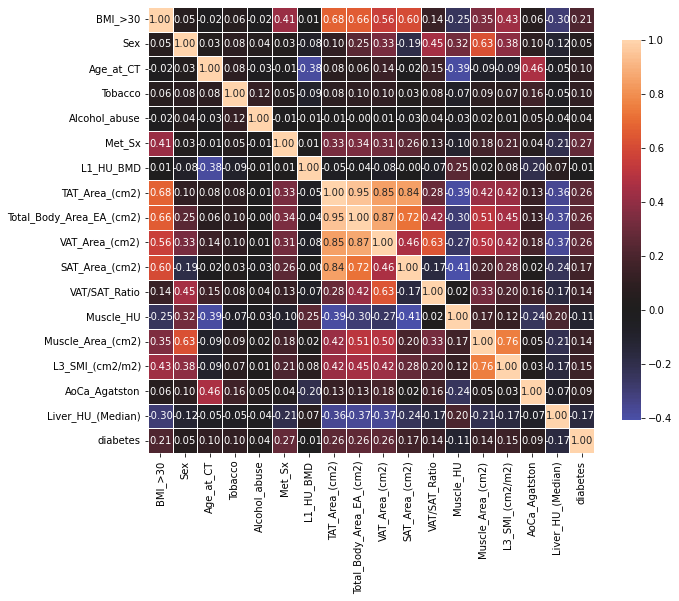

In [157]:
correlations = data.corr()

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f',
            square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70})
plt.show();

In [181]:
ndata = data.copy()
a = 'TAT_Area_(cm2)'
b = 'Total_Body_Area_EA_(cm2)'
#print(ndata[a], ndata[b])
ndata[ncol] = ndata[a]/ndata[b]
ndata.loc[ndata[ncol].isna(), ncol] = 0
ndata = ndata.drop(columns=[a,b, 'VAT_Area_(cm2)', 'SAT_Area_(cm2)'])
#print(ndata[ncol])
print(ndata.shape)

"""
ncol = "Fat_body_area"

ndata.loc[(ndata[a]/ndata[b]) <= 0, ncol] = 1
ndata.loc[(ndata[a]/ndata[b]) > 0, ncol] = 0
ndata.loc[ndata[ncol].isna(), ncol] = 0

#print(ndata[ncol])
ndata = ndata.drop(columns=[a,b, 'VAT_Area_(cm2)', 'SAT_Area_(cm2)'])
#print(ndata.columns)
print(ndata[ncol])
Counter(ndata[ncol])
#ndata.shape
"""

(9223, 15)


'\nncol = "Fat_body_area"\n\nndata.loc[(ndata[a]/ndata[b]) <= 0, ncol] = 1\nndata.loc[(ndata[a]/ndata[b]) > 0, ncol] = 0\nndata.loc[ndata[ncol].isna(), ncol] = 0\n\n#print(ndata[ncol])\nndata = ndata.drop(columns=[a,b, \'VAT_Area_(cm2)\', \'SAT_Area_(cm2)\'])\n#print(ndata.columns)\nprint(ndata[ncol])\nCounter(ndata[ncol])\n#ndata.shape\n'

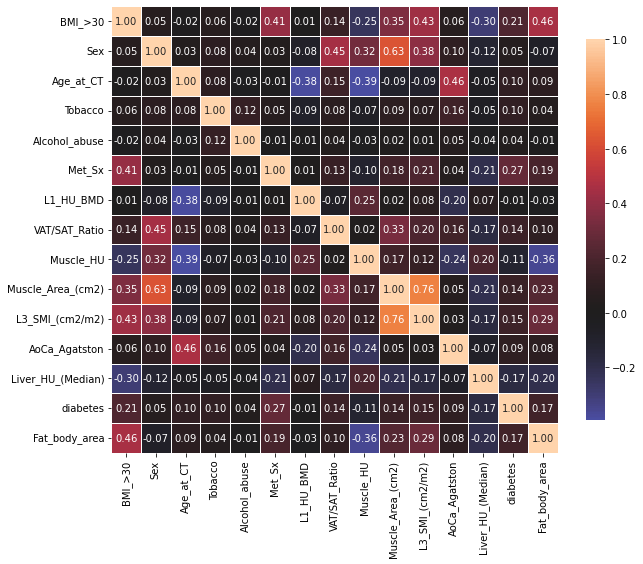

In [182]:

correlations = ndata.corr()

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f',
            square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70})
plt.show();

In [183]:
msk = np.random.rand(data.shape[0]) < 0.8
print(msk)
train = ndata[msk]
test = ndata[~msk]
##print(train)
#print(test)

[ True  True  True ... False  True  True]


In [184]:
feats = list(ndata.columns)
feats.remove(label)
#print(feats)
X_train = train[feats]
y_train = train[label]
X_train = X_train.fillna(0)
y_train = y_train.fillna(0)
print(Counter(y_train))

Counter({0: 5330, 1: 2024})


In [185]:
model = LogisticRegression(random_state=0).fit(X_train, y_train)
#model = Lasso(alpha=0.1).fit(X_train, y_train)

/opt/homebrew/Caskroom/miniforge/base/envs/pytorch_env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [186]:
X_test = test[feats]
Y_test = test[label]
X_test = X_test.fillna(0)
Y_test = Y_test.fillna(0)
print(Counter(Y_test))
preds = model.predict(X_test)
print(preds)
accuracy_score(Y_test, preds)

Counter({0: 1357, 1: 512})
[1 1 1 ... 0 0 0]


0.7388978063135366

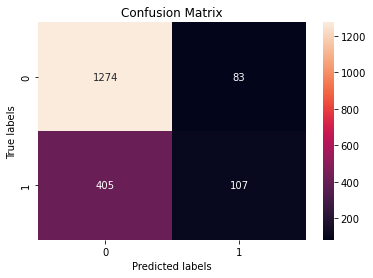

In [187]:
ax= plt.subplot()
cm = confusion_matrix(Y_test, preds)
labels = [0,1]
sns.heatmap(cm, annot=True, fmt='g', ax=ax);
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels);
ax.yaxis.set_ticklabels(labels);

## Heart Attack

In [38]:
# Age at CT
# Tobacco
# BMI
# FRS 10-year risk (%)
# CVD DX
# CVD DX Date [d from CT]
# Heart failure DX
# Heart failure DX Date [d from CT]
# TAT Area (cm2)
# Total Body                
# Area EA (cm2)
# VAT Area (cm2)
# SAT Area (cm2)
# VAT/SAT     Ratio
# AoCa        Agatston
# Liver HU    (Median)

cols = ['Record_ID','BMI','Sex','Age_at_CT','Tobacco','FRS_10-year_risk_(%)','CVD_DX','CVD_DX_Date_[d_from_CT]','Heart_failure_DX','Heart_failure_DX_Date_[d_from_CT]',
'TAT_Area_(cm2)', 'Total_Body_Area_EA_(cm2)', 'VAT_Area_(cm2)','SAT_Area_(cm2)', 'VAT/SAT_Ratio',
 'AoCa_Agatston', 'Liver_HU_(Median)',
        'MI_DX','MI_DX_Date_[d_from_CT]']

In [39]:
data = orig_data[cols].copy()
data['MI'] = np.where(data['MI_DX'].isna(),0,1)

data['FRS_10-year_risk_(%)'] = data['FRS_10-year_risk_(%)'].astype(str)
data['FRS_10-year_risk_(%)'] = data['FRS_10-year_risk_(%)'].str.replace('X','')
data['FRS_10-year_risk_(%)'] = data['FRS_10-year_risk_(%)'].str.replace('<1%',str(np.random.uniform(0, 0.01)))
data['FRS_10-year_risk_(%)'] = data['FRS_10-year_risk_(%)'].str.replace('>30%',str(np.random.uniform(0.3, 0.99)))
data['FRS_10-year_risk_(%)'] = pd.to_numeric(data['FRS_10-year_risk_(%)'], errors='coerce')
data['FRS_10-year_risk_(%)'] = data['FRS_10-year_risk_(%)'].astype(float)
data['FRS_10-year_risk_(%)'] = data['FRS_10-year_risk_(%)'].fillna(data['FRS_10-year_risk_(%)'].median())

data['CVD'] = np.where(data['CVD_DX'].isna(),0,1)
data['CVD'] = np.where(data['CVD_DX_Date_[d_from_CT]']>data['MI_DX_Date_[d_from_CT]'], 0, data['CVD'])

data['Heart_failure'] = np.where(data['Heart_failure_DX'].isna(),0,1)
data['Heart_failure'] = np.where(data['Heart_failure_DX_Date_[d_from_CT]']>data['MI_DX_Date_[d_from_CT]'], 0, data['Heart_failure'])

data['VAT/SAT_Ratio'] = data['VAT/SAT_Ratio'].clip(upper=data['VAT/SAT_Ratio'].quantile(0.95))

data['AoCa_Agatston'] = data['AoCa_Agatston'].clip(upper=data['AoCa_Agatston'].quantile(0.99))
# data['AoCa_Agatston'] = data['AoCa_Agatston'].fillna(data['AoCa_Agatston'].median())
# data['AoCa_Agatston'] = np.log(data['AoCa_Agatston']+1)

data['Liver_HU_(Median)'] = pd.to_numeric(data['Liver_HU_(Median)'], errors='coerce')
data['Liver_HU_(Median)'] = data['Liver_HU_(Median)'].astype(float)
data['Liver_HU_(Median)'] = data['Liver_HU_(Median)'].fillna(data['Liver_HU_(Median)'].median())

data['Sex'] = np.where(data['Sex']=='Male', 1, 0)
data['Tobacco'] = np.where(data['Tobacco']=='Yes', 1, 0)

for col in ['BMI','TAT_Area_(cm2)', 'Total_Body_Area_EA_(cm2)', 'VAT_Area_(cm2)','SAT_Area_(cm2)', 'VAT/SAT_Ratio']:
    data[col] = data[col].fillna(data[col].median())


In [40]:
# Implementing MI recency

data = data[~(data['MI_DX_Date_[d_from_CT]']<0)]
data['MI_recency'] = np.where(data['MI_DX_Date_[d_from_CT]']==0, 1,
                              np.where(data['MI_DX_Date_[d_from_CT]']>0, 
                                       np.log(data['MI_DX_Date_[d_from_CT]']/(1-data['MI_DX_Date_[d_from_CT]'])),
                                       0))
# data['MI_recency'] = np.where(~data['MI_DX_Date_[d_from_CT]'].isna(), 1/(1+np.exp(-1*data['MI_DX_Date_[d_from_CT]'])), 
#                                        1)


/opt/homebrew/Caskroom/miniforge/base/envs/pytorch_env/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/homebrew/Caskroom/miniforge/base/envs/pytorch_env/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [41]:
data['MI_recency'].sort_values()[:50]

0       0.0
6248    0.0
6247    0.0
6246    0.0
6245    0.0
6244    0.0
6243    0.0
6242    0.0
6241    0.0
6240    0.0
6238    0.0
6237    0.0
6236    0.0
6235    0.0
6249    0.0
6234    0.0
6231    0.0
6230    0.0
6229    0.0
6228    0.0
6227    0.0
6226    0.0
6225    0.0
6224    0.0
6223    0.0
6222    0.0
6221    0.0
6220    0.0
6219    0.0
6232    0.0
6250    0.0
6251    0.0
6252    0.0
6284    0.0
6283    0.0
6281    0.0
6280    0.0
6279    0.0
6278    0.0
6277    0.0
6276    0.0
6275    0.0
6274    0.0
6273    0.0
6272    0.0
6271    0.0
6270    0.0
6269    0.0
6267    0.0
6265    0.0
Name: MI_recency, dtype: float64

/opt/homebrew/Caskroom/miniforge/base/envs/pytorch_env/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='MI_recency', ylabel='Density'>

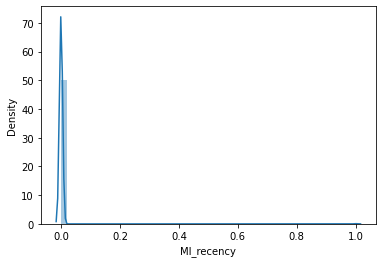

In [42]:
sns.distplot(data['MI_recency']>0)